# Preparation of CMIP6 GHG forcing data

We will have a look at the greenhouse gas concentrations (ghg) that are used for REMO's radiation code to force different emissions scenarios according to CMIP5 and [CMIP6](https://gmd.copernicus.org/articles/9/3461/2016/).
We define some helper functions here to look at the origin REMO ghg tables for CMIP5 which can be found in the DKRZ data pool.

## CMIP5

In [1]:
import glob
import re
from os import path as op

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr


def read_remo_ghg(fname):
    return pd.read_csv(
        fname,
        skiprows=4,
        header=None,
        delim_whitespace=True,
        names=["time", "CO2", "CH4", "N2O", "CFC_11", "CFC_12"],
    )


def get_remo_data(files):
    return {re.findall("rcp[0-9]+", op.basename(f))[0]: read_remo_ghg(f) for f in files}


def get_echam_data(files):
    return {
        re.findall("ssp[0-9]+", op.basename(f))[0]: xr.open_dataset(f) for f in files
    }


def concat(dsets):
    concat_dim = xr.DataArray(list(dsets.keys()), dims="scenario")
    ds = xr.concat(dsets.values(), dim=concat_dim, join="override").squeeze(drop=True)
    ds["time"] = ds.time.astype(int)
    return ds.drop("time_bnds")


def remo_cmip5_df(df_dict):
    for scen, df in df_dict.items():
        df["scenario"] = scen
    return pd.concat(df_dict.values())


def plot_species(ds):
    """plot all species and scenarios"""

    fig = plt.figure(figsize=(10, 15))
    axes = []
    axes.append(plt.subplot2grid((4, 2), (0, 0), colspan=2, rowspan=2))
    axes.append(plt.subplot2grid((4, 2), (2, 0), colspan=1, rowspan=1))
    axes.append(plt.subplot2grid((4, 2), (2, 1), colspan=1, rowspan=1))
    axes.append(plt.subplot2grid((4, 2), (3, 0), colspan=1, rowspan=1))
    axes.append(plt.subplot2grid((4, 2), (3, 1), colspan=1, rowspan=1))

    for i, var in enumerate(ds.data_vars):
        ds[var].plot(ax=fig.axes[i], hue="scenario")
    plt.tight_layout()

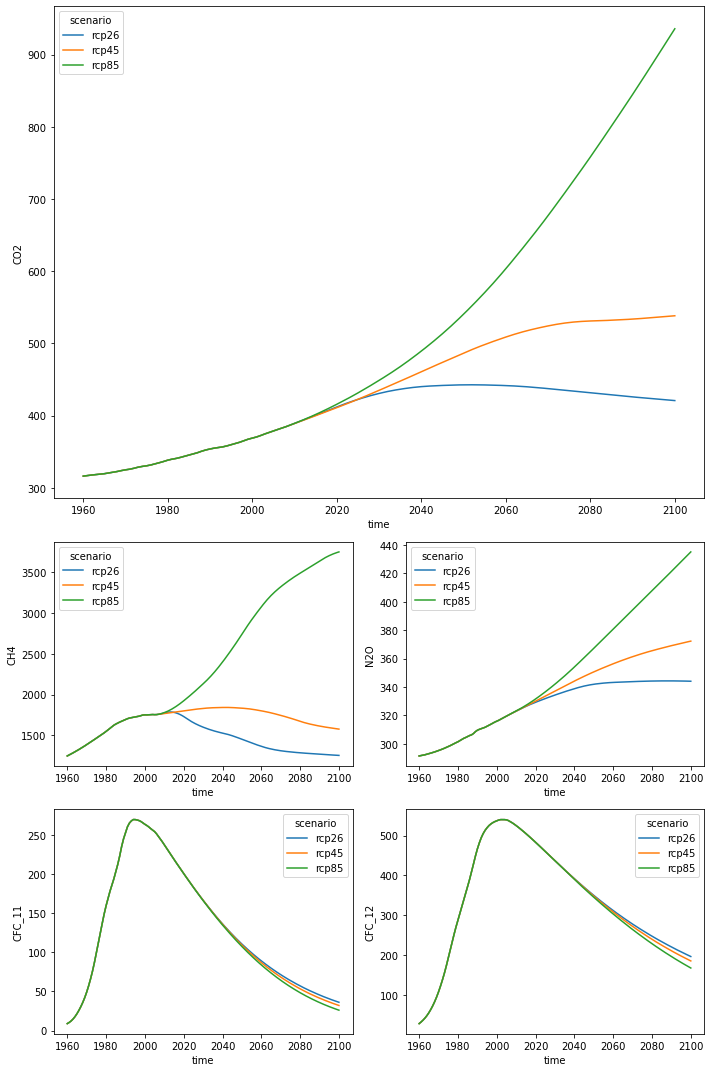

In [2]:
remo_ghg = glob.glob("/pool/data/remo/GHG_*_1850-2101.txt")
remo_ghg.sort()
remo_cmip5 = get_remo_data(remo_ghg)
remo_cmip5_ds = remo_cmip5_df(remo_cmip5).set_index(["time", "scenario"]).to_xarray()
plot_species(remo_cmip5_ds.sel(time=slice("1960", "2100")))

Those are the CMIP5 rcp scenarios, that have been used for most of the recent REMO runs that were driven by CMIP5 datasets.

## input4MIPs

For CMIP6, we will use the data from [input4MIPs](https://esgf-data.dkrz.de/projects/input4mips-dkrz/) where ESGF provides forcing datasets for CMIP6. At DKRZ we find:

In [3]:
scenarios = [
    op.basename(f)
    for f in glob.glob(
        "/work/kd0956/INPUT4MIPS/data/input4MIPs/CMIP6/ScenarioMIP/UoM/*"
    )
]
scenarios

['UoM-REMIND-MAGPIE-ssp585-1-2-1',
 'UoM-GCAM4-ssp434-1-2-1',
 'UoM-REMIND-MAGPIE-ssp534-over-1-2-0',
 'UoM-IMAGE-ssp119-1-2-1',
 'UoM-GCAM4-ssp460-1-2-0',
 'UoM-GCAM4-ssp460-1-2-1',
 'UoM-GCAM4-ssp434-1-2-0',
 'UoM-IMAGE-ssp126-1-2-1',
 'UoM-MESSAGE-GLOBIOM-ssp245-1-2-0',
 'UoM-AIM-ssp370-1-2-0',
 'UoM-IMAGE-ssp126-1-2-0',
 'UoM-REMIND-MAGPIE-ssp585-1-2-0',
 'UoM-IMAGE-ssp119-1-2-0',
 'UoM-MESSAGE-GLOBIOM-ssp245-1-2-1',
 'UoM-REMIND-MAGPIE-ssp534-over-1-2-1',
 'UoM-AIM-ssp370-1-2-1',
 'UoM-ssp126-1-1-0']

For REMO, we requires the following species and experiment ids:

In [4]:
mapping = {
    "mole_fraction_of_carbon_dioxide_in_air": "CO2",
    "mole_fraction_of_methane_in_air": "CH4",
    "mole_fraction_of_nitrous_oxide_in_air": "N2O",
    "mole_fraction_of_cfc11_in_air": "CFC_11",
    "mole_fraction_of_cfc12_in_air": "CFC_12",
}

scenarios = {
    "UoM-IMAGE-ssp119-1-2-0": "ssp119",
    "UoM-IMAGE-ssp126-1-2-0": "ssp126",
    "UoM-MESSAGE-GLOBIOM-ssp245-1-2-1": "ssp245",
    "UoM-AIM-ssp370-1-2-1": "ssp370",
    "UoM-REMIND-MAGPIE-ssp585-1-2-1": "ssp585",
}

Let's define some helpful functions to access the different scenario and species datasets at DKRZ:

In [5]:
def get_url(source_id, variable_id, activity_id):
    return f"/work/kd0956/INPUT4MIPS/data/input4MIPs/CMIP6/{activity_id}/UoM/{source_id}/atmos/yr/{variable_id}/gr1-GMNHSH/*/*"


def create_historical_dataset(mapping, sector=0):
    """ """
    # decode_times = False, since calendar is no cf standard.
    ds = create_dataset(
        "UoM-CMIP-1-2-0", mapping, "CMIP", sector=sector, decode_times=False
    )
    ds["time"] = np.arange(ds.dims["time"])

    return ds


def create_dataset(source_id, mapping, activity_id, sector=0, **kwargs):
    mapp = mapping
    if source_id == "UoM-CMIP-1-2-0":
        # For some reason, here the variables names are written with "minus"
        # instead of underscore(?), weired... we replace underscore with minus then...
        mapp = {k.replace("_", "-"): v for k, v in mapp.items()}
    urls = []
    for key in mapp.keys():
        url = get_url(source_id, key, activity_id)
        paths = glob.glob(url)
        if len(paths) > 1:
            raise Exception("no unique selection")
        elif len(paths) == 0:
            print(url)
            raise Exception("no files found")
        urls.append(paths[0])
    ds = (
        xr.open_mfdataset(urls, **kwargs)
        .isel(sector=0, drop=True)
        .drop(["time_bnds", "sector_bnds"])
    )
    for var in ds.data_vars:
        ds[var].attrs["long_name"] = var
    return ds.rename(mapping)


def all_scenarios(mapping, scenarios):
    dsets = {
        s: create_dataset(key, mapping, "ScenarioMIP") for key, s in scenarios.items()
    }
    dim = xr.DataArray(list(dsets.keys()), dims="scenario")
    return xr.concat(list(dsets.values()), dim=dim)

In [6]:
hist = create_historical_dataset(mapping)
scens = all_scenarios(mapping, scenarios)
scens["time"] = scens.time.dt.year

We create one big datasets containing all species and scenarios to get an overview. Then we can have a look.

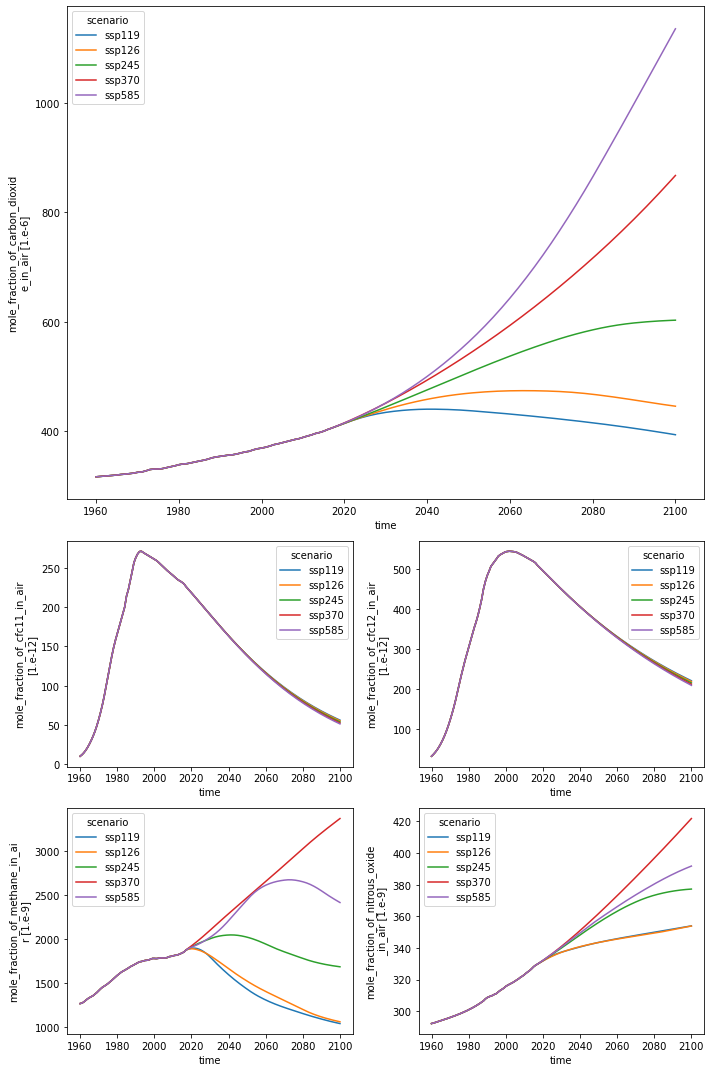

In [7]:
ds = xr.concat([hist, scens], dim="time")
plot_species(ds.sel(time=slice("1960", "2100")))

write the tables to REMO formatted txt input files:

In [8]:
def write_table(ds, scen, start=1850, end=2101):
    data = ds.sel(scenario=scen)  # .squeeze(drop=True)
    df = (
        data.rename(time="year")
        .sel(year=slice(start, end))
        .drop("scenario")
        .to_dataframe()
        .reset_index()[["year", "CO2", "CH4", "N2O", "CFC_11", "CFC_12"]]
    )
    data = df.to_string(
        index=False, header=False, float_format="%.2f", col_space=8, justify="left"
    )
    header = (
        f"{scen}\n"
        "time     CO2       CH4     N2O        CFC_11   CFC_12\n"
        "year     ppmv      ppbv    ppbv       pptv     pptv\n\n"
    )
    ref = "\n\nreference: https://pyremo.readthedocs.io/en/stable/ghg-forcing.html"
    txt = header + data + ref
    filename = f"GHG_{scen}_{start}-{end}.txt"
    with open(filename, "w") as f:
        f.write(txt)
    return filename


[write_table(ds, scen) for scen in ds.scenario.values]

['GHG_ssp119_1850-2101.txt',
 'GHG_ssp126_1850-2101.txt',
 'GHG_ssp245_1850-2101.txt',
 'GHG_ssp370_1850-2101.txt',
 'GHG_ssp585_1850-2101.txt']